In [1]:
import os, sys
import numpy as np
from astropy import units, constants
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize, curve_fit
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d
from lmfit import Model
import lmfit, emcee
from lightkurve.lightcurve import LightCurve
from plasmapy.formulary.radiation import thermal_bremsstrahlung

import warnings
warnings.filterwarnings("ignore")

from astropy.modeling import models
from astropy.nddata import NDUncertainty

In [2]:
wavelength, flux, flux_err = np.load('continuum_bump.npy', allow_pickle=True)

## For MCMC fits

In [3]:
def log_likelihood(theta, x, y, yerr):
    T, scaling = theta
    model = bb(x, T, scaling)
    sigma2 = yerr ** 2 + model ** 2 #* np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    T, scaling = theta
    if T > 1e4 and T < 1e10 and scaling > 0.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

## Blackbody function

In [4]:
def bb(x, T, scaling):
    T *= units.K
    x *= units.AA
    frac = 2.0 * constants.h * constants.c**2 / x**5
    exp = (constants.h * constants.c) / (x * constants.k_B * T)
    func =  frac * 1.0/(np.exp(exp) - 1.0)
    func = func.to(units.erg/units.s/units.AA/units.cm**2)
    return func

## Thermal Bremsstrahlung function

Reference: https://casper.astro.berkeley.edu/astrobaki/index.php/Thermal_Bremsstrahlung

$j_{\nu, ff} = \frac{16}{3 \sqrt{2 \pi}} \frac{Z^2 e^6}{m_e^{3/2} c^3 (kT)^{1/2}} n_e^2 e^{-h\nu/kT}$

In [5]:
def j_ff(mu, T, Z, ne):
    term1 = 16.0 / (3.0 * np.sqrt(2*np.pi))
    term2 = Z**2/(constants.m_e**1.5 * constants.c**3 * np.sqrt(constants.k_B * T))
    frac = (constants.h * mu) / (constants.k_B * T)
    j = term1 * term2 * ne**2.0 * np.exp(-frac)
    return j

$a_{\nu, ff} = \frac{8}{3 \sqrt{2 \pi}} \frac{Z^2 e^6}{m_e^{3/2} c (kT)^{1/2}} \frac{n_e^2}{h \nu^3} \left( 1 - e^{-h\nu/kt}\right)$

In [6]:
def a_ff(mu, T, Z, ne):
    term1 = 8.0 / (3 * np.sqrt(2*np.pi))
    term2 = Z**2 / (constants.m_e**1.5 * constants.c * np.sqrt(constants.k_B * T))
    term3 = ne**2 / (constants.h * mu**3)
    frac = (constants.h * mu) / (constants.k_B * T)
    return term1 * term2 * term3 * (1 - np.exp(-frac))

## PlasmaPy thermal bremsstrahlung

In [7]:
def plasma_brem(x, Te, ne, scaling, offset):
    spectrum = thermal_bremsstrahlung(x, ne*units.cm**-3, Te*units.K)
    s = spectrum.to(units.erg /units.s * units.s / units.cm ** 2 / units.AA)
    s = s/(25000*2*units.s)
    s = np.log10(s.value)/scaling+offset
    return s

## Plotting & Comparing models

(500.0, 1500.0)

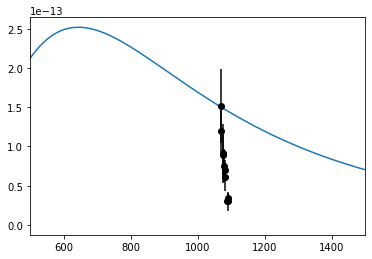

In [83]:
w = np.arange(0.000001,600000,1)*units.AA  # wavelengths to evaluate over
mu = (constants.c/w).to(units.Hz)        # frequency

T = 5000*units.K         # Temperature
ne = 1e8*units.cm**-3    # electron number density
Z = 1
j = j_ff(mu, T, Z, ne)   # volume emissivity
a = a_ff(mu, T, Z, ne)   # inverse bremsstrahlung

#plt.loglog(mu, (j/a).to(units.erg/units.m**2)/100)


plt.errorbar(wavelength[0],
              flux[0], 
              yerr=flux_err[0],
              marker='o', linestyle='', color='k', zorder=2)

plt.plot(np.arange(0,3200,1),
         bb(np.arange(0,3200,1), 4.5*10**4, 1).value/3e23)
#plt.yscale('log')
plt.xlim(500,1500)
#plt.ylim(10**-22, 10**-3)

In [84]:
wavelength[0]

array([1068.50127314, 1069.50127314, 1075.50127314, 1076.50127314,
       1079.50127314, 1080.50127314, 1081.50127314, 1088.50127314,
       1089.50127314, 1090.50127314])

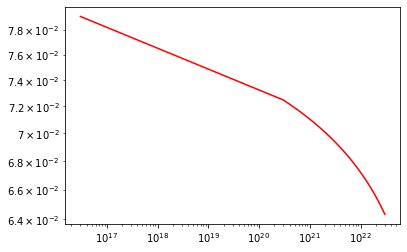

In [57]:
plasma = plasma_brem(np.linspace(3e16, 3e22, 100), 10**13, 4*10**22, 10, 0)
plt.loglog(np.linspace(3e16, 3e22, 100), 10**plasma, 'r')